\tableofcontents


\newpage

# Settings

In [3]:
import pyspark
sc = pyspark.SparkContext(appName="Regression Task")


In [4]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, IntegerType, StringType
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.sql import SQLContext

\newpage

# Data Preparation

## Reading the data

In [6]:
sqlContext = SQLContext(sc)
#indexer needed so that labels are 0 and 1

schema = StructType([ StructField("c"+str(0),StringType())]+
                    [ StructField("c"+str(i),DoubleType()) for i in range(1,9)])
# schema to cast data, can use inferschema also

raw_data = sqlContext.read.csv(
    "/content/drive/MyDrive/exo3_train.csv",schema=schema)


#droping rows with nulls
raw_data_nn = raw_data.dropna()

assembled_data = VectorAssembler(inputCols=["c"+str(i) 
                for i in range(1,8)],outputCol="features").transform(raw_data_nn)


/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


## Standardizing the data

In [52]:
#standardizing the data
scale=StandardScaler(inputCol='features',outputCol='standardized_features')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)

## Removing outliers

In [125]:
"""
Applied according to :
How to remove outliers from multiple columns in pyspark 
using mean and standard deviation
(from Stackoverflow)
"""

numeric_cols = ['c1', 'c2', 'c3', 'c4','c5','c6', 'c7']
mean_std = \
    train \
    .groupBy('c0', 'c8') \
    .agg( \
      *[f.mean(colName).alias('mean_{}'.format(colName)) for colName in numeric_cols],\
      *[f.stddev(colName).alias('stddev_{}'.format(colName)) for colName in numeric_cols])
    
mean_std_min_max = mean_std
for colName in numeric_cols:
    meanCol = 'mean_{}'.format(colName)
    stddevCol = 'stddev_{}'.format(colName)
    minCol = 'min_{}'.format(colName)
    maxCol = 'max_{}'.format(colName)
    mean_std_min_max = mean_std_min_max.withColumn(minCol, f.col(meanCol) - 5 * f.col(stddevCol))
    mean_std_min_max = mean_std_min_max.withColumn(maxCol, f.col(meanCol) + 5 * f.col(stddevCol))

outliers = train.join(mean_std_min_max, how = 'left', on = ['c0'])
for colName in numeric_cols:
    isOutlierCol = 'is_outlier_{}'.format(colName)
    minCol = 'min_{}'.format(colName)
    maxCol = 'max_{}'.format(colName)
    meanCol = 'mean_{}'.format(colName)
    stddevCol = 'stddev_{}'.format(colName)
    outliers = outliers.withColumn(isOutlierCol, 
                                   f.when((f.col(colName) > f.col(maxCol)) | 
                                          (f.col(colName) < f.col(minCol)), 1).
                                   otherwise(0))    
    outliers = outliers.drop(minCol,maxCol, meanCol, stddevCol)    

In [132]:
print("With the mean and standard deviation, we have found", 
      outliers.filter((f.col("is_outlier_c1")!=f.lit(0)) |
                (f.col("is_outlier_c2")!=f.lit(0)) |
                (f.col("is_outlier_c3")!=f.lit(0)) |
                (f.col("is_outlier_c4")!=f.lit(0)) |
                (f.col("is_outlier_c5")!=f.lit(0)) |
                (f.col("is_outlier_c6")!=f.lit(0)) |
                (f.col("is_outlier_c7")!=f.lit(0))).count(),
      "outliers. (*￣m￣)")

With the mean and standard deviation, we have found 0 outliers. (*￣m￣)


## Exploring the data

In [8]:
import pandas as pd

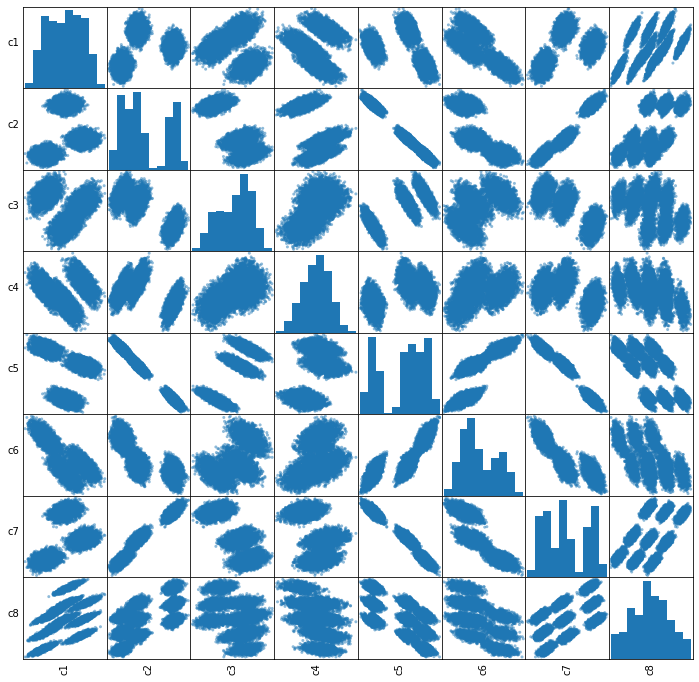

In [9]:
sampled_data = data_scale_output.select(["c"+str(i) for i in range(1,9)]).
                                                  sample(False, 0.8).toPandas()
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(12,12))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

The most important part of the previous visualization is the last colum since it represents the corelation between the taget values and the features.
Therefor we notice some correlation between some of the variables and the target.

## Split into training and validation

For the model selection, we have to divide our dataset into a training set and a validation set. We set the training ratio to be 80% of the dataset.

In [10]:
train, val = data_scale_output.randomSplit([0.8, 0.2], seed=12345)

\newpage

# Model Selection

## Linear Regression

In [11]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [55]:
# Building the model
lr = LinearRegression(featuresCol = 'standardized_features', 
                      labelCol='c8', 
                      maxIter=10, 
                      regParam=0.3, 
                      elasticNetParam=0.8)

lr_model = lr.fit(train)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

Coefficients: [240.9285986458868,292.6629305671314,173.50830089598722,-217.70702407591259,-114.51404850928375,203.0092587153934,-89.89095612048393]
Intercept: 186.17661860197106
RMSE: 222.477192
r2: 0.719846


In [56]:
# Making the predictions
lr_predictions = lr_model.transform(val)
lr_predictions.select("prediction","c8","features").show(5)

lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="c8",metricName="r2")

print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+------+--------------------+
|        prediction|    c8|            features|
+------------------+------+--------------------+
| 528.4347866392004|1020.0|[446.0,461.0,-27....|
| 361.5438430116119| 354.0|[784.0,-848.0,196...|
| 551.8219666928418| 730.0|[515.0,202.0,-265...|
| 334.6315028322394| 220.0|[408.0,-14.0,-368...|
|471.15826441272804| 736.0|[829.0,-995.0,24....|
+------------------+------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.705601


### Parameters tuning

In [86]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

lr = LinearRegression(featuresCol = 'standardized_features', 
                      labelCol='c8', 
                      solver="normal")

# Evaluate model
lr_evaluator = RegressionEvaluator(predictionCol="prediction", 
                                   labelCol="c8", 
                                   metricName="rmse")

# Create ParamGrid for Cross Validation
lr_paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [1e-2, 1e-3, 1e-4, 1e-5])
             .addGrid(lr.elasticNetParam, [0.0, 0.25])
             .addGrid(lr.maxIter, [1, 2, 5])
             .build())

# Create 4-fold CrossValidator
lr_cv = CrossValidator(estimator = lr,
                    estimatorParamMaps = lr_paramGrid,
                    evaluator = lr_evaluator,
                    numFolds = 4)

# Run cross validations
lr_cv_Model = lr_cv.fit(data_scale_output)
print(lr_cv_Model)

# Get Model Summary Statistics
lr_cv_Summary = lr_cv_Model.bestModel.summary
print("Coefficient Standard Errors: " + str(lr_cv_Summary.coefficientStandardErrors))

CrossValidatorModel_9a6729a15d9a
Coefficient Standard Errors: [2.6750193208107875, 12.496692273090728, 2.5127277408447344, 1.5465671392467242, 14.840759881676508, 6.373236267906828, 8.546833266216035, 3.8375043042082986]


In [149]:
print("The best model has the following parameters:")
print("\t"*6,"MaxIter=", lr_cv_Model.bestModel.getMaxIter())
print("\t"*6,"NetParam=", lr_cv_Model.bestModel.getElasticNetParam())
print("\t"*6,"RegParam=", lr_cv_Model.bestModel.getRegParam())

The best model has the following parameters:
						 MaxIter= 1
						 NetParam= 0.0
						 RegParam= 0.001


In [61]:
# Use velidation set here so we can measure the accuracy of our model on new data
lr_predictions = lr_cv_Model.transform(val)

lr_score = lr_cv_Summary.rootMeanSquaredError

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
print('RMSE:', lr_score)

RMSE: 82.00958198000126


In [60]:
lr_predictions.select("prediction","c8","features").show(10)

lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="c8",metricName="r2")

print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+-------------------+------+--------------------+
|         prediction|    c8|            features|
+-------------------+------+--------------------+
|  927.0563429044515|1020.0|[446.0,461.0,-27....|
|   438.671052424401| 354.0|[784.0,-848.0,196...|
|  811.0902390756099| 730.0|[515.0,202.0,-265...|
|  280.9446575758557| 220.0|[408.0,-14.0,-368...|
|  719.5481187387066| 736.0|[829.0,-995.0,24....|
|   693.980796280758| 631.0|[672.0,-842.0,238...|
| 1037.3125565078024|1179.0|[732.0,222.0,-240...|
|  832.7614185609549| 959.0|[438.0,62.0,-451....|
| 236.28262055046167| 389.0|[322.0,-1484.0,29...|
|-177.21209555850294|-320.0|[200.0,-1283.0,27...|
+-------------------+------+--------------------+
only showing top 10 rows

R Squared (R2) on test data = 0.960351


### Visualization of LR

From the following visualization we notice how the target and the predictions superpose in the space which attests of the relative good predictions made by the model.

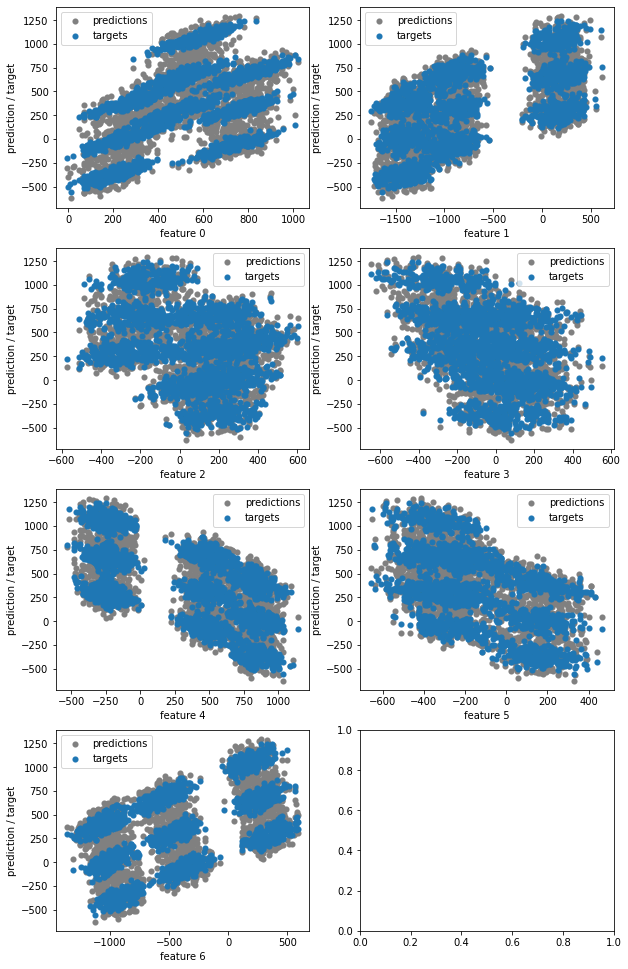

In [185]:
ft = [w.features for w in lr_predictions.select('features').collect()]
pred = [w.prediction for w in lr_predictions.select('prediction').collect()]
true = [w.c8 for w in lr_predictions.select('c8').collect()]

sort = sorted(range(len(true)), key=lambda k: true[k])
sorted_pred = [pred[i] for i in sort]
sorted_true = [true[i] for i in sort]

fig, ax = plt.subplots(7//2+1, 7%2+1,figsize=(10,17))

for i in range(7):
  c = [f[i] for f in ft]
  sorted_c = [c[i] for i in sort]
  ax[i//2, i%2].scatter(sorted_c, sorted_pred, color='grey', linewidth=0.1, label= 'predictions')
  ax[i//2, i%2].scatter(sorted_c, sorted_true, linewidth=0.1, label= 'targets')
  ax[i//2, i%2].set_xlabel('feature '+ str(i))
  ax[i//2, i%2].set_ylabel('prediction / target')
  ax[i//2, i%2].legend()
plt.show()

\newpage

## Decision Tree Regression

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'c8')
dt_model = dt.fit(train)
dt_predictions = dt_model.transform(val)
dt_evaluator = RegressionEvaluator(
    labelCol="c8", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on validation data = %g" % rmse)

Root Mean Squared Error (RMSE) on validation data = 237.499


In [ ]:
dt_model.featureImportances

SparseVector(7, {0: 0.2846, 1: 0.0203, 2: 0.0698, 3: 0.0222, 4: 0.454, 6: 0.1491})

### Parameters tuning

In [ ]:
# Evaluate model
evaluator = RegressionEvaluator(
    labelCol="c8", predictionCol="prediction", metricName="rmse")

# Create ParamGrid for Cross Validation
paramGrid = ParamGridBuilder().addGrid(dt.maxDepth, 
                                       [2, 5, 10, 20, 30]).
                                       addGrid(dt.maxBins, 
                                               [10, 40, 100]).
                                               build()

# Create 5-fold CrossValidator
cvs = CrossValidator(estimator=dt,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    # 80% of the data will be used for training, 20% for validation.
                    numFolds=5)

# Run cross validations
cvs_model = cvs.fit(train)
print(cvs_Model)

CrossValidatorModel_a7f5e34b3bba


In [ ]:
cvs_predictions = cvs_model.transform(val)
evaluator.evaluate(cvs_predictions)

145.0533679351754

In [ ]:
# Use velidation set here so we can measure the accuracy of our model on new data
dt_predictions = cvs_model.transform(val)

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
print('RMSE:', evaluator.evaluate(dt_predictions))

RMSE: 145.0533679351754


In [ ]:
dt_predictions.select("prediction","c8","features").show(10)

evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="c8",metricName="r2")

print("R Squared (R2) on test data = %g" % evaluator.evaluate(dt_predictions))

+----------+------+--------------------+
|prediction|    c8|            features|
+----------+------+--------------------+
|    1034.0|1020.0|[446.0,461.0,-27....|
|     701.0| 354.0|[784.0,-848.0,196...|
|     741.0| 730.0|[515.0,202.0,-265...|
|     232.0| 220.0|[408.0,-14.0,-368...|
|     739.0| 736.0|[829.0,-995.0,24....|
|     613.0| 631.0|[672.0,-842.0,238...|
|    1168.0|1179.0|[732.0,222.0,-240...|
|     938.0| 959.0|[438.0,62.0,-451....|
|     394.0| 389.0|[322.0,-1484.0,29...|
|    -330.0|-320.0|[200.0,-1283.0,27...|
+----------+------+--------------------+
only showing top 10 rows

R Squared (R2) on test data = 0.874884


In [ ]:
dt_evaluator = RegressionEvaluator(
    labelCol="c8", predictionCol="prediction", metricName="rmse")
dtr_rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on validation data = %g" % rmse)

Root Mean Squared Error (RMSE) on validation data = 112.314


\newpage

## Gradient-boosted tree regression

In [18]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'c8', maxIter=10)
gbt_model = gbt.fit(train)
gbt_predictions = gbt_model.transform(val)
gbt_predictions.select('prediction', 'c8', 'features').show(5)

+------------------+------+--------------------+
|        prediction|    c8|            features|
+------------------+------+--------------------+
| 514.5688085108319|1020.0|[446.0,461.0,-27....|
| 623.8457698169174| 354.0|[784.0,-848.0,196...|
|1010.8209828200846| 730.0|[515.0,202.0,-265...|
| 364.8186941829988| 220.0|[408.0,-14.0,-368...|
| 571.1635744816143| 736.0|[829.0,-995.0,24....|
+------------------+------+--------------------+
only showing top 5 rows



In [ ]:
gbt_evaluator = RegressionEvaluator(
    labelCol="c8", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 182.743


### Parameters tuning

In [19]:
# Evaluate model
evaluator = RegressionEvaluator(
    labelCol="c8", predictionCol="prediction", metricName="rmse")

# Create ParamGrid for Cross Validation
paramGrid = ParamGridBuilder()\
  .addGrid(gbt.maxDepth, [2, 5, 10])\
  .addGrid(gbt.maxIter, [10, 50])\
  .build()

# Create 5-fold CrossValidator
gb = CrossValidator(estimator=gbt,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    # 80% of the data will be used for training, 20% for validation.
                    numFolds=5)

# Run cross validations
gb_model = gb.fit(train)
print(gb_model)

CrossValidatorModel_5e8522c33aa8


In [20]:
evaluator = RegressionEvaluator(
    labelCol="c8", predictionCol="prediction", metricName="rmse")
gb_predictions = gb_model.bestModel.transform(val)
gb_score = evaluator.evaluate(gb_predictions)
print('Rmse obtained is', gb_score)

Rmse obtained is 127.95867390709157


\newpage

## Comparing results

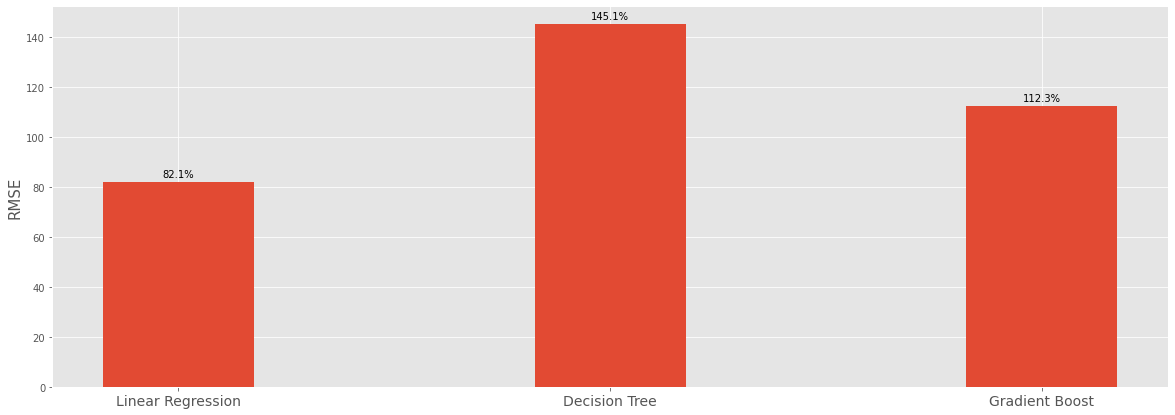

In [ ]:
I = ['Linear Regression', 'Decision Tree', 'Gradient Boost']
L = [lr_score, dtr_rmse, gb_score]

labels = L
x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots(figsize=(20,7))
rects1 = ax.bar(x, L, width)

def autolabel(rects, labels):
    i=0
    for rect in rects:
        height = rect.get_height()
        ax.annotate(s = str(labels[i])+'%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        i+=1

labels1 = [round(A_SVM_sorte, 1) for A_SVM_sorte in L]
autolabel(rects1, labels1)


ax.set_ylabel('RMSE', size = 15)
ax.set_xticks(x)
ax.set_xticklabels(I, size = 14)

plt.show()

We get much better results on the Linear Regression than in the two other models.
Therefore we will choose this model for the rest of the project.

## Ensemble Method

In [36]:
lr_df = lr_predictions.select(lr_predictions["c0"].alias("c0_lr"), lr_predictions["prediction"].alias("lr_pred"), lr_predictions["c8"])
gb_df = gb_predictions.select(gb_predictions["c0"].alias("c0_gb"), gb_predictions["prediction"].alias("gb_pred"))

In [142]:
from pyspark.sql.functions import col
# finding good compromize between weight of prediction to Gradient Boost and Linear Regression
for lr_a in range(0,15):

  marksColumns = [col('lr_pred')] + [col('gb_pred')]*lr_a

  averageFunc = sum(x for x in marksColumns)/len(marksColumns)

  df = gb_df.join(lr_df, lr_df["c0_lr"]==gb_df["c0_gb"], "inner")

  ens = df.withColumn('ens_pred', averageFunc).select(col("c0_gb").alias("index"), col("ens_pred").alias("prediction"), col("c8").alias("label"))
  
  evaluator = RegressionEvaluator(
      labelCol="label", predictionCol="prediction", metricName="rmse")
  score = evaluator.evaluate(ens)
  print(lr_a, score)

0 222.50513985032347
1 148.66018770825247
2 133.34879846641687
3 128.55487052280907
4 126.73643162225233
5 125.98846107999964
6 125.68639417619252
7 125.5878893870486
8 125.58736711333606
9 125.63489774271443
10 125.70545467580429
11 125.78598818210368
12 125.86953638095635
13 125.9523657479568
14 126.03250974003987


The ensemble method path was not conclusive, the results were worse than for a simple Linear Regression

\newpage

# Testing

## Reading the data

In [ ]:
schema = StructType([ StructField("c"+str(0),StringType())]+[ StructField("c"+str(i),DoubleType()) for i in range(1,9)])
# schema to cast data, can use inferschema also

raw_data = sqlContext.read.csv("/content/drive/MyDrive/exo3_predict.csv",schema=schema)

assembled_data = VectorAssembler(inputCols=["c"+str(i) for i in range(1,8)],outputCol="features").transform(raw_data)

#standardizing the data
scale=StandardScaler(inputCol='features',outputCol='standardized_features')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)

## Making the predictions

In [ ]:
test_lr_predictions = lr_cv_Model.transform(data_scale_output)

## Saving the results

In [ ]:
pred = [w.prediction for w in test_lr_predictions.select('prediction').collect()]
ind = [w.c0 for w in test_lr_predictions.select('c0').collect()]

with open('exo3.csv','wb') as file:
  for p, i in zip(pred, ind):
    file.write((str(i)+','+str(p)+'\n').encode())

In [188]:
!jupyter nbconvert --to pdf --TemplateExporter.exclude_input=False "Regression_Task_:_Saad_Lahlali.ipynb"

[NbConvertApp] Converting notebook Regression_Task_:_Saad_Lahlali.ipynb to pdf
[NbConvertApp] Support files will be in Regression_Task_:_Saad_Lahlali_files/
[NbConvertApp] Making directory ./Regression_Task_:_Saad_Lahlali_files
[NbConvertApp] Making directory ./Regression_Task_:_Saad_Lahlali_files
[NbConvertApp] Making directory ./Regression_Task_:_Saad_Lahlali_files
[NbConvertApp] Writing 81127 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: [u'xelatex', u'./notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: [u'bibtex', u'./notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 479824 bytes to Regression_Task_:_Saad_Lahlali.pdf
